In [68]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
    
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chiara.manna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/chiara.manna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chiara.manna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_2 = pd.read_csv('preprocessed_dataset2.csv') #dataset obtained from CFLW

In [ ]:
df_2.groupby(by="tags").count() 

In [4]:
df_2.info()
print(df_2.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   domain_id    2401 non-null   int64 
 1   page_id      2401 non-null   int64 
 2   snapshot_id  2401 non-null   int64 
 3   tags         2401 non-null   object
 4   text         2401 non-null   object
 5   text_len     2401 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 112.7+ KB
domain_id      0
page_id        0
snapshot_id    0
tags           0
text           0
text_len       0
dtype: int64


Label aggregation

In [5]:
conditions = [(df_2["tags"] == "Gift Cards") | (df_2["tags"] == "Gambling") | (df_2["tags"] == "Credit Cards") |\
              (df_2["tags"] == "Credit Cards,Gift Cards"), (df_2["tags"] == "Leaked Data") | (df_2["tags"] == "Hacking,Leaked Data") |\
                 (df_2["tags"] == "Hacked Accounts,Leaked Data") | (df_2["tags"] == "Hacking") |\
                 (df_2["tags"] =="Hacked Accounts,Hacking") | (df_2["tags"] == "Hacked Accounts"),\
                  (df_2["tags"] == "Drugs / Narcotics"), \
                    (df_2["tags"] == "Hitman"),\
                      (df_2["tags"] == "Weapons")]
classes = ["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Violent Crime", "Weapons Trade"]
df_2["label"] = np.select(conditions, classes, default= "")
df_2= df_2[df_2.label.isin(classes)]


Text length distribution

In [ ]:
df_2.describe()

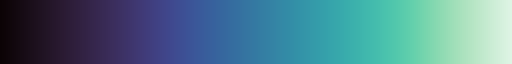

In [7]:
sns.set(rc={'figure.figsize':(8,6)})
sns.color_palette("mako", as_cmap=True)

Text(0, 0.5, 'Text length')

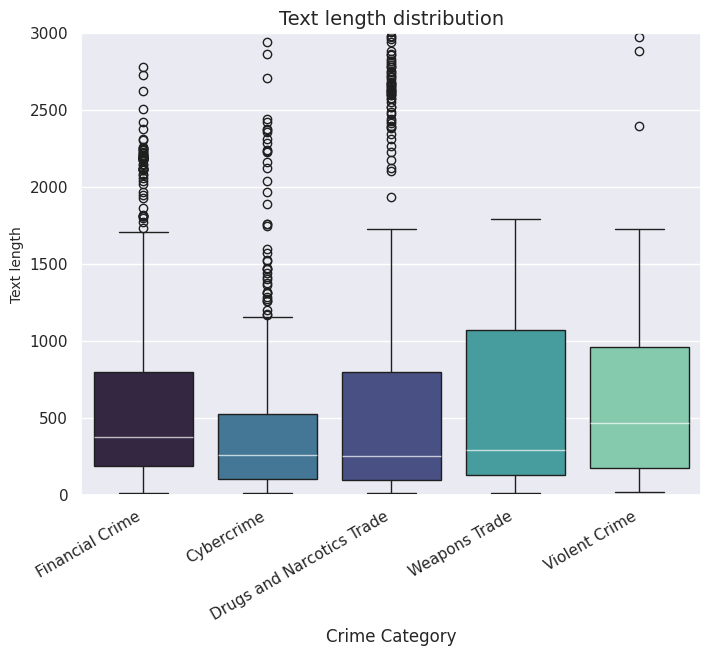

In [8]:
sns.boxplot(data=df_2, y = 'text_len', x= 'label', hue='label', palette='mako', medianprops=dict(color="white", alpha=0.7), order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.title("Text length distribution", fontsize = 14)
plt.suptitle("")
plt.ylim(0,3000)
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Text length', fontsize = 10)

In [9]:
df_2.text_len[(df_2.text_len <= 400)].count() #58% below

1256

Class distribution

In [10]:
df_2.groupby("label").count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,646,646,646,646,646,646
Drugs and Narcotics Trade,509,509,509,509,509,509
Financial Crime,820,820,820,820,820,820
Violent Crime,56,56,56,56,56,56
Weapons Trade,109,109,109,109,109,109


Text(0.5, 1.0, 'Class imbalance')

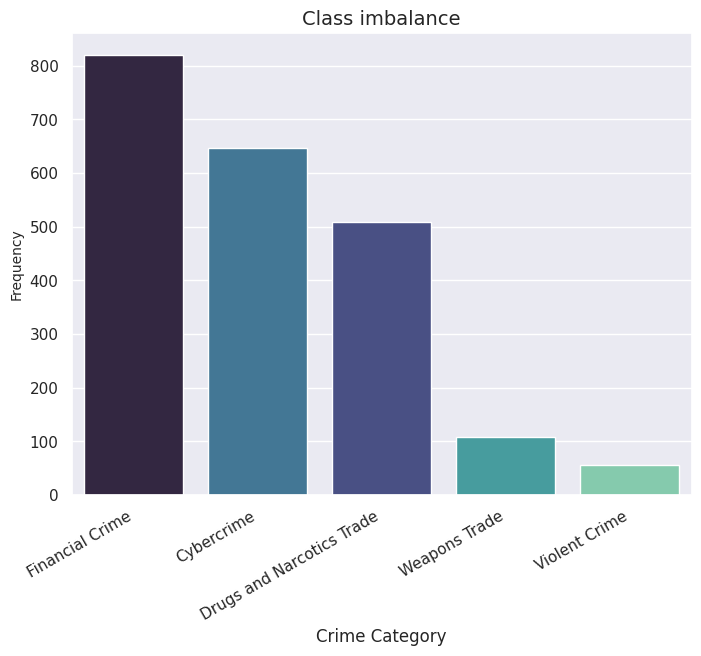

In [11]:
sns.countplot(data=df_2, x= "label", hue="label", palette='mako',order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.title('Class imbalance', fontsize = 14)

Text cleaning

In [12]:
df_2['text'] = df_2['text'].apply(lambda text: re.sub(r'\b(?:\+\d{1,2}\s?)?\(?(?:\d{1,4})?\)?[-.\s]?\d{1,5}[-.\s]?\d{1,5}[-.\s]?\d{1,9}\b', '', text)) #remove phone numbers
df_2['text'] = df_2['text'].apply(lambda text: re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', '', text)) #remove email addresses

In [13]:
df_2['text'] = df_2['text'].apply(lambda text: re.sub(r'[^\x00-\x7F]+', '', text)) #removes non basic ASCII character, to remove non English characters
df_2['text'] = df_2['text'].apply(lambda text: re.sub(r'[^\w\s.?!,:;\'"\d-]', '', text)) #removes uncommon punctuation

In [14]:
df_2['text'] = df_2['text'].apply(lambda x: x.replace('.onion', ''))
df_2['text'] = df_2['text'].apply(lambda x: re.sub(r'\s-\s', ' ', x))
df_2['text'] = df_2['text'].apply(lambda x: x.replace('.JS', ''))
df_2['text'] = df_2['text'].apply(lambda x: x.replace("'s", ''))
df_2['text'] = df_2['text'].apply(lambda x: re.sub(r'(?i)www', '', x))
df_2['text'] = df_2['text'].apply(lambda x: x.replace('\r', ''))
#remove 's .onion - if surrounded by space .JS Www \r remove single characters surrounded by space

Resulting text distribution after preprocessing

In [ ]:
df_2['text_len'] = df_2['text'].apply(lambda x: len(x.split()))
df_2.describe() 

In [16]:
df_2 = df_2[df_2.text_len >= 10] #remove instances of less than 10 words to not exclude noise
df_2.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,646,646,646,646,646,646
Drugs and Narcotics Trade,507,507,507,507,507,507
Financial Crime,820,820,820,820,820,820
Violent Crime,56,56,56,56,56,56
Weapons Trade,109,109,109,109,109,109


In [ ]:
df_2.describe()

In [18]:
df_2.text_len[(df_2.text_len <= 400)].count() #58% below

1255

In [ ]:
print(df_2.groupby("label")["text_len"].median())
df_2.groupby("label")["text_len"].describe()

Text(0, 0.5, 'Text length')

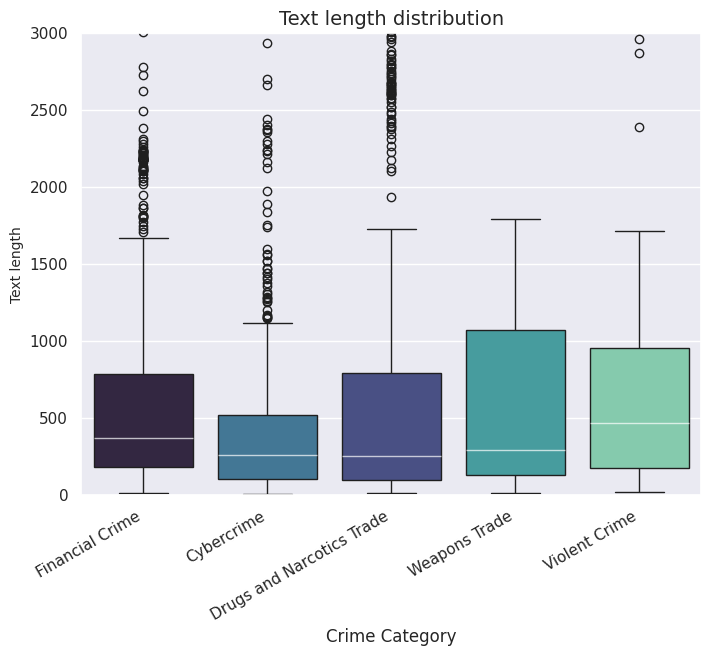

In [20]:
sns.set(rc={'figure.figsize':(8,6)})
sns.color_palette("mako", as_cmap=True)
sns.boxplot(data=df_2, y = 'text_len', x= 'label', hue='label', palette='mako', medianprops=dict(color="white", alpha=0.7), order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.title("Text length distribution", fontsize = 14)
plt.suptitle("")
plt.ylim(0,3000)
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Text length', fontsize = 10)

Text(0.5, 1.0, 'Class imbalance')

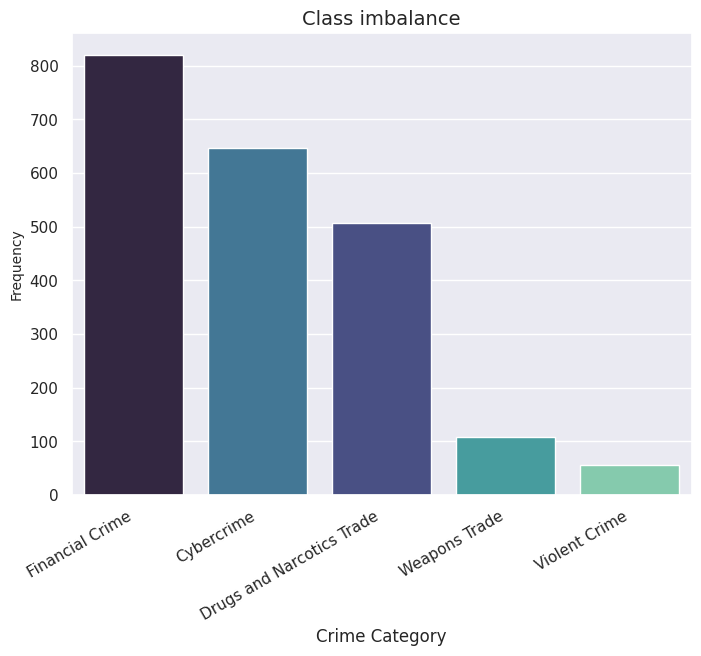

In [21]:

sns.countplot(data=df_2, x= "label", hue="label", palette='mako',order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.title('Class imbalance', fontsize = 14)

In [ ]:
#df_2.to_csv("dataset_2.csv")

Error Analysis --> Text Overlap

In [80]:
df_trainval = pd.read_csv('nolower_datasplit/trainval_nolower.csv', index_col=0)

In [81]:
df_aug_violent_crime = pd.read_csv('processed_datasets/aug_violent_crime_pro.csv', index_col=0).reset_index(drop=True)
df_aug_violent_crime = df_aug_violent_crime[['text', 'label']].sample(n=611, random_state=42) 
df_aug_weapons_trade = pd.read_csv('processed_datasets/aug_weapons_trade_pro.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade = df_aug_weapons_trade[['text', 'label']].sample(n=569, random_state=42)
df_aug_cybercrime = pd.read_csv('processed_datasets/aug_cybercrime_pro.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime = df_aug_cybercrime[['text', 'label']].sample(n=139, random_state=42)
df_aug_drugs_trade = pd.read_csv('processed_datasets/aug_drugs_trade_pro.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade = df_aug_drugs_trade[['text', 'label']].sample(n=251, random_state=42)
df_aug_trainval = pd.concat([ df_trainval[['text', 'label']], df_aug_violent_crime,df_aug_weapons_trade, df_aug_cybercrime, df_aug_drugs_trade], ignore_index=True)

In [82]:
df_aug_violent_crime_train_quant = pd.read_csv('processed_datasets_08/aug_violent_crime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_train_quant = pd.read_csv('processed_datasets_08/aug_cybercrime_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_train_quant = pd.read_csv('processed_datasets_08/aug_weapons_trade_08_pro.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_train_quant = pd.read_csv('processed_datasets_08/aug_drugs_trade_08_pro.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_train_quant2 = df_aug_violent_crime_train_quant[['text', 'label']].sample(n=611, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_train_quant2 = df_aug_cybercrime_train_quant[['text', 'label']].sample(n=139, random_state=42)
df_aug_weapons_trade_train_quant2 = df_aug_weapons_trade_train_quant[['text', 'label']].sample(n=569, random_state=42)
df_aug_drugs_trade_train_quant2 = df_aug_drugs_trade_train_quant[['text', 'label']].sample(n=251, random_state=42)

df_aug_trainval_quant = pd.concat([df_trainval[['text', 'label']], df_aug_cybercrime_train_quant2, df_aug_drugs_trade_train_quant2, df_aug_violent_crime_train_quant2, df_aug_weapons_trade_train_quant2], ignore_index=True)


In [83]:
df_aug_violent_crime_trainval_fs = pd.read_csv('processed_datasets_08/aug_violent_crime_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_cybercrime_trainval_fs = pd.read_csv('processed_datasets_08/aug_cybercrime_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_weapons_trade_trainval_fs = pd.read_csv('processed_datasets_08/aug_weapons_trade_08_trainval_FS.csv', index_col=0).reset_index(drop=True)
df_aug_drugs_trade_trainval_fs = pd.read_csv('processed_datasets_08/aug_drugs_trade_08_trainval_FS.csv', index_col=0).reset_index(drop=True)

df_aug_violent_crime_trainval_fs = df_aug_violent_crime_trainval_fs[['text', 'label']].sample(n=611, random_state=42) #datasets already consist of synthetic only, otherwise need to subset
df_aug_cybercrime_trainval_fs = df_aug_cybercrime_trainval_fs[['text', 'label']].sample(n=139, random_state=42)
df_aug_weapons_trade_trainval_fs = df_aug_weapons_trade_trainval_fs[['text', 'label']].sample(n=569, random_state=42)
df_aug_drugs_trade_trainval_fs = df_aug_drugs_trade_trainval_fs[['text', 'label']].sample(n=251, random_state=42)

df_aug_trainval_fs = pd.concat([ df_trainval[['text', 'label']], df_aug_cybercrime_trainval_fs, df_aug_drugs_trade_trainval_fs, df_aug_violent_crime_trainval_fs, df_aug_weapons_trade_trainval_fs], ignore_index=True)

Error analysis: Text overlap

In [84]:
def remove_stopwords_and_lemmatize(text):
    
    text = re.sub(r'[^\w\s]', '', text)
    
    
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]

    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

def top_words_and_overlap(df, top_n):
    class_word_freq = {}  
    top_words = {}  
    
    #Copy so not all preprocessing steps are applied
    df_copy = df.copy()
    df_copy['text'] = df_copy['text'].apply(remove_stopwords_and_lemmatize)

    for class_name, texts in df_copy.groupby('label')['text']:
        words = ' '.join(texts).lower().split()
        class_word_freq[class_name] = Counter(words)

        top_words[class_name] = dict(class_word_freq[class_name].most_common(top_n))

    common_words = set(list(class_word_freq.values())[0].keys())
    for freq in class_word_freq.values():
        common_words = common_words.intersection(set(freq.keys()))

    results = {
        'top_words': top_words,
        'common_words': common_words,
        'overlap': bool(common_words)
    }

    class_combinations = [(class1, class2) for i, class1 in enumerate(class_word_freq.keys()) for class2 in list(class_word_freq.keys())[i+1:]]
    class_similarities = {}

    for class1, class2 in class_combinations:
        set1 = set(class_word_freq[class1].keys())
        set2 = set(class_word_freq[class2].keys())
        jaccard_similarity = len(set1.intersection(set2)) / len(set1.union(set2))
        class_similarities[(class1, class2)] = jaccard_similarity

    results['class_similarities'] = class_similarities

    return results

def plot_word_cloud(ax, words, title, font_size=20, colormap='viridis'):
    if not words:
        print("No common words")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=len(words),
                          colormap=colormap, prefer_horizontal=0.9, max_font_size=font_size).generate_from_frequencies(words)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=font_size)


In [ ]:
top_n = 20  #Top n words to consider
results = top_words_and_overlap(df_trainval, top_n)

top_words_lists = []

for class_name, top_words in results['top_words'].items():
    print(f"Top {top_n} words for '{class_name}':")
    print(top_words)
    print()

    top_words_lists.append(list(top_words.keys()))

#Wordclouds
num_classes = len(results['top_words'])
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i, (class_name, top_words) in enumerate(results['top_words'].items()):
    common_words_freq = {word: freq for word, freq in top_words.items()}
    wordcloud = WordCloud(width=2000, height=1400, background_color='white',
                          colormap= 'viridis', prefer_horizontal=0.8).generate_from_frequencies(common_words_freq)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Class: {class_name}', fontsize = 18)

plt.tight_layout()
plt.show()

if results['overlap']:
    print("There are common words across classes.")
else:
    print("No common words found across classes.")



#Vectors-based pairwise semantic similarity
nlp = spacy.load("en_core_web_md")


top_words_vectors = {class_name: [nlp(word).vector for word in top_words.keys()] 
                     for class_name, top_words in results['top_words'].items()}

semantic_similarities = {}
class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    vectors_class1 = top_words_vectors[class1]
    vectors_class2 = top_words_vectors[class2]
    
    mean_vector_class1 = sum(vectors_class1) / len(vectors_class1)
    mean_vector_class2 = sum(vectors_class2) / len(vectors_class2)
    
    similarity = cosine_similarity([mean_vector_class1], [mean_vector_class2])[0][0]
    
    semantic_similarities[(class1, class2)] = similarity


print("\nCosine Similarities:")
for (class1, class2), similarity in semantic_similarities.items():
    print(f"'{class1}' and '{class2}' have a cosine similarity of {similarity:.2f}")

common_top_words = set.intersection(*map(set, top_words_lists))
print(f"\nTop {top_n} words common across all classes:")
print(common_top_words)

pairwise_intersections = {}
common_words_list = []

class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    top_words_class1 = set(results['top_words'][class1].keys())
    top_words_class2 = set(results['top_words'][class2].keys())
    intersection = top_words_class1.intersection(top_words_class2)
    pairwise_intersections[(class1, class2)] = intersection

    #intersection of top words for each pair of classes
    print(f"\nTop word intersections between '{class1}' and '{class2}':")
    print(intersection)
    common_words_list.extend(intersection)




In [ ]:
top_n = 20  #top n words to consider
results = top_words_and_overlap(df_aug_trainval, top_n)

top_words_lists = []

for class_name, top_words in results['top_words'].items():
    print(f"Top {top_n} words for '{class_name}':")
    print(top_words)
    print()

    top_words_lists.append(list(top_words.keys()))

#wordclouds
num_classes = len(results['top_words'])
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i, (class_name, top_words) in enumerate(results['top_words'].items()):
    common_words_freq = {word: freq for word, freq in top_words.items()}
    wordcloud = WordCloud(width=2000, height=1400, background_color='white',
                          colormap= 'viridis', prefer_horizontal=0.8).generate_from_frequencies(common_words_freq)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Class: {class_name}', fontsize = 18)

plt.tight_layout()
plt.show()

if results['overlap']:
    print("There are common words across classes.")
else:
    print("No common words found across classes.")


#Vectors-based pairwise semantic similarity
top_words_vectors = {class_name: [nlp(word).vector for word in top_words.keys()] 
                     for class_name, top_words in results['top_words'].items()}

semantic_similarities = {}
class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    vectors_class1 = top_words_vectors[class1]
    vectors_class2 = top_words_vectors[class2]
    
    mean_vector_class1 = sum(vectors_class1) / len(vectors_class1)
    mean_vector_class2 = sum(vectors_class2) / len(vectors_class2)
    
    similarity = cosine_similarity([mean_vector_class1], [mean_vector_class2])[0][0]
    
    semantic_similarities[(class1, class2)] = similarity


print("\nCosine Similarities:")
for (class1, class2), similarity in semantic_similarities.items():
    print(f"'{class1}' and '{class2}' have a cosine similarity of {similarity:.2f}")

common_top_words = set.intersection(*map(set, top_words_lists))
print(f"\nTop {top_n} words common across all classes:")
print(common_top_words)

pairwise_intersections = {}
common_words_list = []

class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    top_words_class1 = set(results['top_words'][class1].keys())
    top_words_class2 = set(results['top_words'][class2].keys())
    intersection = top_words_class1.intersection(top_words_class2)
    pairwise_intersections[(class1, class2)] = intersection

    #intersection of top words for each pair of classes
    print(f"\nTop word intersections between '{class1}' and '{class2}':")
    print(intersection)
    common_words_list.extend(intersection)


In [ ]:
top_n = 20  #top n words to consider
results = top_words_and_overlap(df_aug_trainval_quant, top_n)

top_words_lists = []

for class_name, top_words in results['top_words'].items():
    print(f"Top {top_n} words for '{class_name}':")
    print(top_words)
    print()

    top_words_lists.append(list(top_words.keys()))

#wordclouds
num_classes = len(results['top_words'])
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i, (class_name, top_words) in enumerate(results['top_words'].items()):
    common_words_freq = {word: freq for word, freq in top_words.items()}
    wordcloud = WordCloud(width=2000, height=1400, background_color='white',
                          colormap= 'viridis', prefer_horizontal=0.8).generate_from_frequencies(common_words_freq)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Class: {class_name}', fontsize = 18)

plt.tight_layout()
plt.show()

if results['overlap']:
    print("There are common words across classes.")
else:
    print("No common words found across classes.")

#Vectors-based pairwise semantic similarity
top_words_vectors = {class_name: [nlp(word).vector for word in top_words.keys()] 
                     for class_name, top_words in results['top_words'].items()}

semantic_similarities = {}
class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    vectors_class1 = top_words_vectors[class1]
    vectors_class2 = top_words_vectors[class2]
    
    mean_vector_class1 = sum(vectors_class1) / len(vectors_class1)
    mean_vector_class2 = sum(vectors_class2) / len(vectors_class2)
    
    similarity = cosine_similarity([mean_vector_class1], [mean_vector_class2])[0][0]
    
    semantic_similarities[(class1, class2)] = similarity


print("\nCosine Similarities:")
for (class1, class2), similarity in semantic_similarities.items():
    print(f"'{class1}' and '{class2}' have a cosine similarity of {similarity:.2f}")

common_top_words = set.intersection(*map(set, top_words_lists))
print(f"\nTop {top_n} words common across all classes:")
print(common_top_words)

pairwise_intersections = {}
common_words_list = []

class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    top_words_class1 = set(results['top_words'][class1].keys())
    top_words_class2 = set(results['top_words'][class2].keys())
    intersection = top_words_class1.intersection(top_words_class2)
    pairwise_intersections[(class1, class2)] = intersection

    #intersection of top words for each pair of classes
    print(f"\nTop word intersections between '{class1}' and '{class2}':")
    print(intersection)
    common_words_list.extend(intersection)


In [ ]:
top_n = 20  #top n words to consider
results = top_words_and_overlap(df_aug_trainval_fs, top_n)

top_words_lists = []

for class_name, top_words in results['top_words'].items():
    print(f"Top {top_n} words for '{class_name}':")
    print(top_words)
    print()

    top_words_lists.append(list(top_words.keys()))

#wordclouds
num_classes = len(results['top_words'])
fig, axes = plt.subplots(1, num_classes, figsize=(20, 5))

for i, (class_name, top_words) in enumerate(results['top_words'].items()):
    common_words_freq = {word: freq for word, freq in top_words.items()}
    wordcloud = WordCloud(width=2000, height=1400, background_color='white',
                          colormap= 'viridis', prefer_horizontal=0.8).generate_from_frequencies(common_words_freq)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'Class: {class_name}', fontsize = 18)

plt.tight_layout()
plt.show()

if results['overlap']:
    print("There are common words across classes.")
else:
    print("No common words found across classes.")

#Vectors-based pairwise semantic similarity
top_words_vectors = {class_name: [nlp(word).vector for word in top_words.keys()] 
                     for class_name, top_words in results['top_words'].items()}

semantic_similarities = {}
class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    vectors_class1 = top_words_vectors[class1]
    vectors_class2 = top_words_vectors[class2]
    
    mean_vector_class1 = sum(vectors_class1) / len(vectors_class1)
    mean_vector_class2 = sum(vectors_class2) / len(vectors_class2)
    
    similarity = cosine_similarity([mean_vector_class1], [mean_vector_class2])[0][0]
    
    semantic_similarities[(class1, class2)] = similarity


print("\nCosine Similarities:")
for (class1, class2), similarity in semantic_similarities.items():
    print(f"'{class1}' and '{class2}' have a cosine similarity of {similarity:.2f}")

common_top_words = set.intersection(*map(set, top_words_lists))
print(f"\nTop {top_n} words common across all classes:")
print(common_top_words)

pairwise_intersections = {}
common_words_list = []

class_combinations = combinations(results['top_words'].keys(), 2)

for class1, class2 in class_combinations:
    top_words_class1 = set(results['top_words'][class1].keys())
    top_words_class2 = set(results['top_words'][class2].keys())
    intersection = top_words_class1.intersection(top_words_class2)
    pairwise_intersections[(class1, class2)] = intersection

    #intersection of top words for each pair of classes
    print(f"\nTop word intersections between '{class1}' and '{class2}':")
    print(intersection)
    common_words_list.extend(intersection)
